# California Housing Prices - ML Project

The dataset is about housing prices in California. It is used to predict the median house value (median_house_value) in different districts based on various demographic and geographic characteristics.

Main task: Regression problem to predict the continuous variable median_house_value.

## Preparation

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn

# Main Libraries
import pandas as pd
import numpy as np
import math

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_validate

In [ ]:
from google.colab import files
uploaded = files.upload()
import os
os.listdir('/content')

csv_file_path = "/content/housing.csv"
df = pd.read_csv(csv_file_path)

df.head()

Saving housing.csv to housing.csv


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Description of Data

### Dataset description

In [ ]:
# Check for null values in each column
print(df.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [ ]:
# Display the data types of each column
print(df.dtypes)

# Display the number of rows and columns
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object
Number of rows: 20640
Number of columns: 10


### Numerical variables visualization

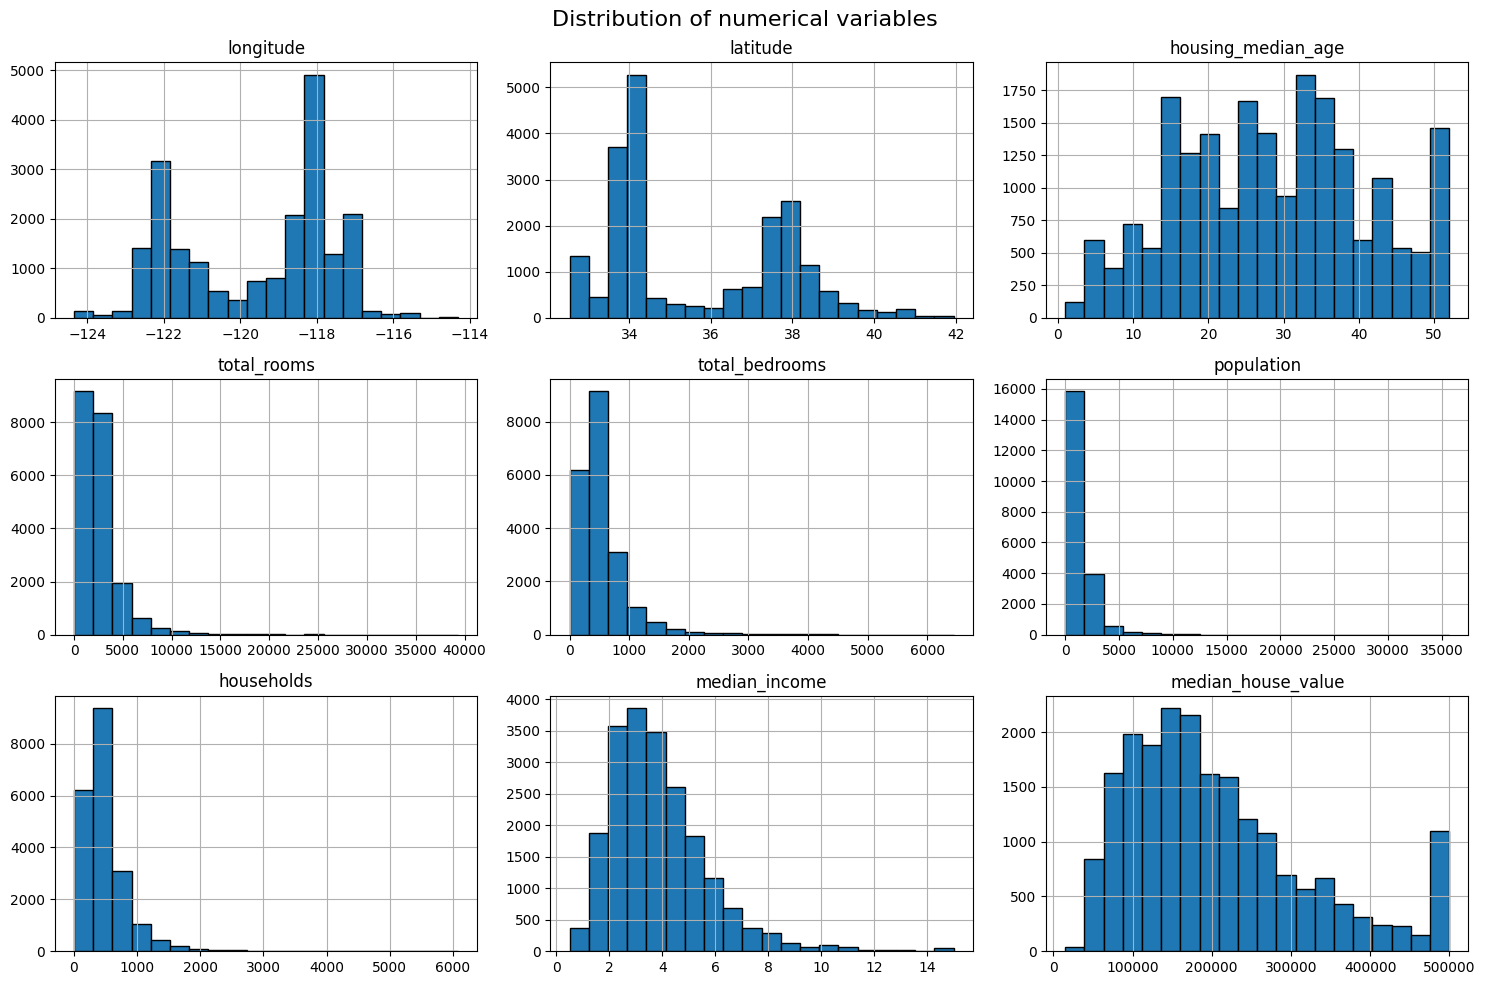

In [ ]:
# Select numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plotting histograms for numerical feature
df[numeric_columns].hist(bins=20, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribution of numerical variables", fontsize=16)
plt.tight_layout()
plt.show()

### Categorical variables visualization

<ipython-input-6-b0231dbcdd1c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ocean_proximity_counts.index, y=ocean_proximity_counts.values, palette="viridis")


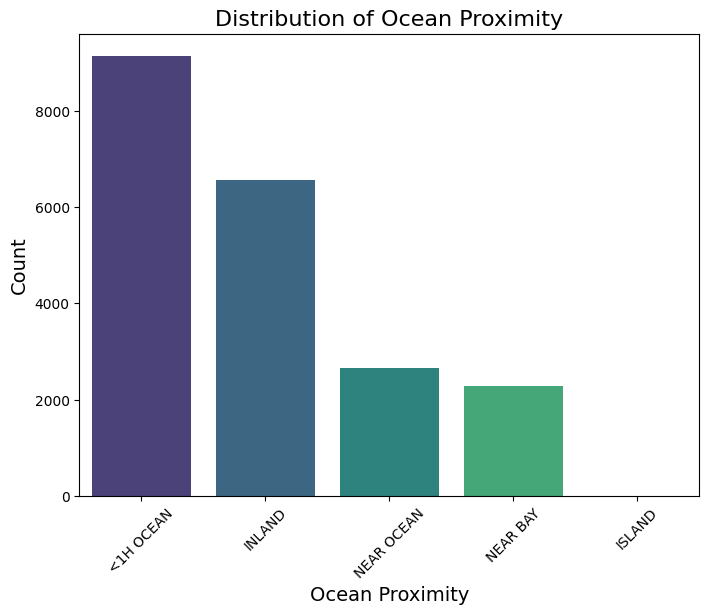

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


In [ ]:
# Count the occurrences of each category for the unique categorical feature
ocean_proximity_counts = df['ocean_proximity'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=ocean_proximity_counts.index, y=ocean_proximity_counts.values, palette="viridis")

# Add labels and title
plt.title("Distribution of Ocean Proximity", fontsize=16)
plt.xlabel("Ocean Proximity", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()

print(ocean_proximity_counts)

### Correlation Heatmap

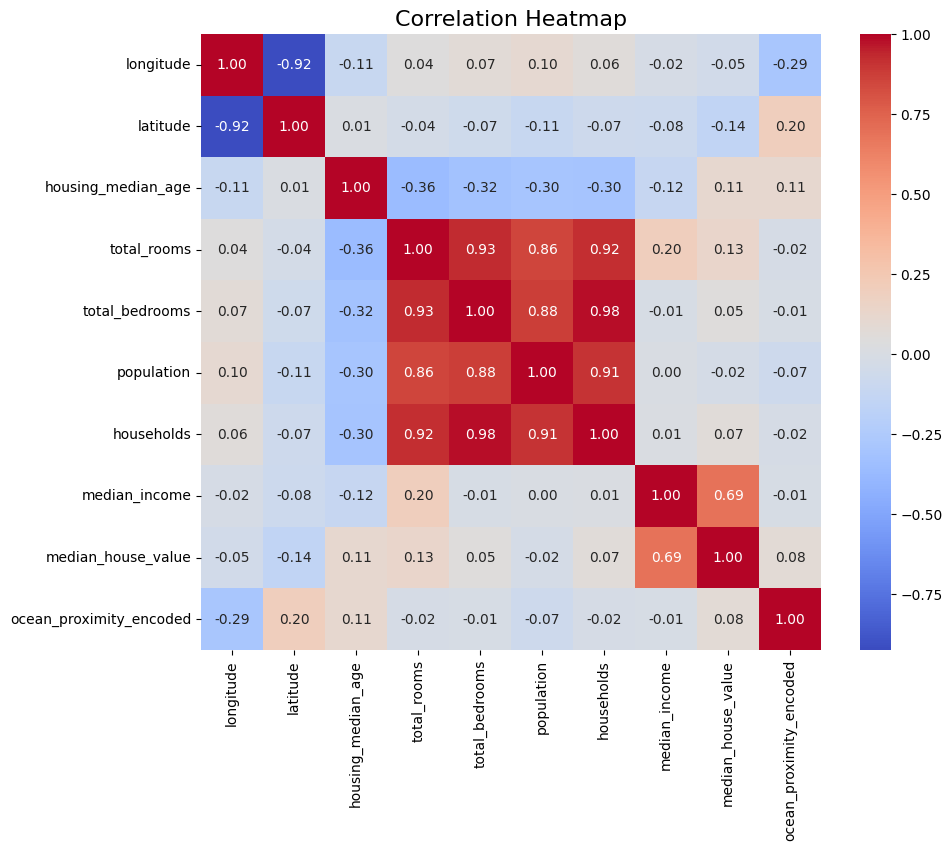

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Apply Ordinal Encoding to ocean_proximity column
encoder = OrdinalEncoder()
df['ocean_proximity_encoded'] = encoder.fit_transform(df[['ocean_proximity']])

# Correlation calculation
columns_to_include = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
correlation_matrix = df[columns_to_include].corr()

# Show correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

## Data Cleaning

In [ ]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_encoded
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


### Missing values

In [ ]:
# Drop rows with any null values
df.dropna(inplace=True)

# Display the number of rows and columns after dropping null values
print(f"Number of rows after dropping null values: {df.shape[0]}")
print(f"Number of columns after dropping null values: {df.shape[1]}")

Number of rows after dropping null values: 20433
Number of columns after dropping null values: 11


### Outliers

In [ ]:
# Calcul des statistiques descriptives
stats_summary = df[numeric_columns].describe()

# Calcul de l'Intervalle Interquartile (IQR) pour identifier les valeurs aberrantes
Q1 = df[numeric_columns].quantile(0.25)  # 1er quartile
Q3 = df[numeric_columns].quantile(0.75)  # 3e quartile
IQR = Q3 - Q1  # Intervalle interquartile

# Outlier Detection
outliers = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR)))
print("Number of outliers per column :\n", outliers.sum())

Number of outliers per column :
 longitude                0
latitude                 0
housing_median_age       0
total_rooms           1290
total_bedrooms        1271
population            1190
households            1210
median_income          670
median_house_value    1064
dtype: int64


In [ ]:
#  Outlier Imputation - Replacing Outliers with the Median
for col in numeric_columns:
    median = df[col].median()
    #The pandas "where" method keeps the values ​​that satisfy a condition (~outliers[col] non outliers) and replaces the others with a given value.
    df[col] = df[col].where(~outliers[col], median)

### Inconsistent or redundant data

In [ ]:
# Check the logical limits of variables
print("Inconsistent values ​​for median_income :", df[df['median_income'] < 0])
print("Inconsistent values ​​for longitude and latitude :", df[(df['longitude'] < -125) | (df['longitude'] > -114) | (df['latitude'] < 32) | (df['latitude'] > 42)])

# Check for inconsistencies between total_rooms and total_bedrooms
print("Inconsistencies between total_rooms and total_bedrooms :")
print(df[df['total_rooms'] < df['total_bedrooms']])

# Check unique categories in ocean_proximity
print("Unique categories in ocean_proximity:", df['ocean_proximity'].unique())

Inconsistent values ​​for median_income : Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity, ocean_proximity_encoded]
Index: []
Inconsistent values ​​for longitude and latitude : Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity, ocean_proximity_encoded]
Index: []
Inconsistencies between total_rooms and total_bedrooms :
Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity, ocean_proximity_encoded]
Index: []
Unique categories in ocean_proximity: ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [ ]:
# Identify feature pairs with absolute correlation > 0.9
strongly_correlated = correlation_matrix[correlation_matrix.abs() > 0.9]
print("Highly Correlated Attributes :\n", strongly_correlated)

# Find exact duplicates
duplicates = df.duplicated()
print("Number of duplicates :", duplicates.sum())

Highly Correlated Attributes :
                          longitude  latitude  housing_median_age  total_rooms  \
longitude                 1.000000 -0.924664                 NaN          NaN   
latitude                 -0.924664  1.000000                 NaN          NaN   
housing_median_age             NaN       NaN                 1.0          NaN   
total_rooms                    NaN       NaN                 NaN     1.000000   
total_bedrooms                 NaN       NaN                 NaN     0.930380   
population                     NaN       NaN                 NaN          NaN   
households                     NaN       NaN                 NaN     0.918484   
median_income                  NaN       NaN                 NaN          NaN   
median_house_value             NaN       NaN                 NaN          NaN   
ocean_proximity_encoded        NaN       NaN                 NaN          NaN   

                         total_bedrooms  population  households  \
longitude

In [ ]:
#Delete feature strongly correlated - Delete column "total_dedrooms" and "households"
redundant_columns = ['total_bedrooms', 'households']
df.drop(columns=redundant_columns, inplace=True)

df.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,median_house_value,ocean_proximity,ocean_proximity_encoded
0,-122.23,37.88,41.0,880.0,322.0,3.5365,452600.0,NEAR BAY,3.0
1,-122.22,37.86,21.0,2127.0,2401.0,3.5365,358500.0,NEAR BAY,3.0
2,-122.24,37.85,52.0,1467.0,496.0,7.2574,352100.0,NEAR BAY,3.0
3,-122.25,37.85,52.0,1274.0,558.0,5.6431,341300.0,NEAR BAY,3.0
4,-122.25,37.85,52.0,1627.0,565.0,3.8462,342200.0,NEAR BAY,3.0


## Feature Engineering

### Visualizing relationships between “median_house_value” and other features

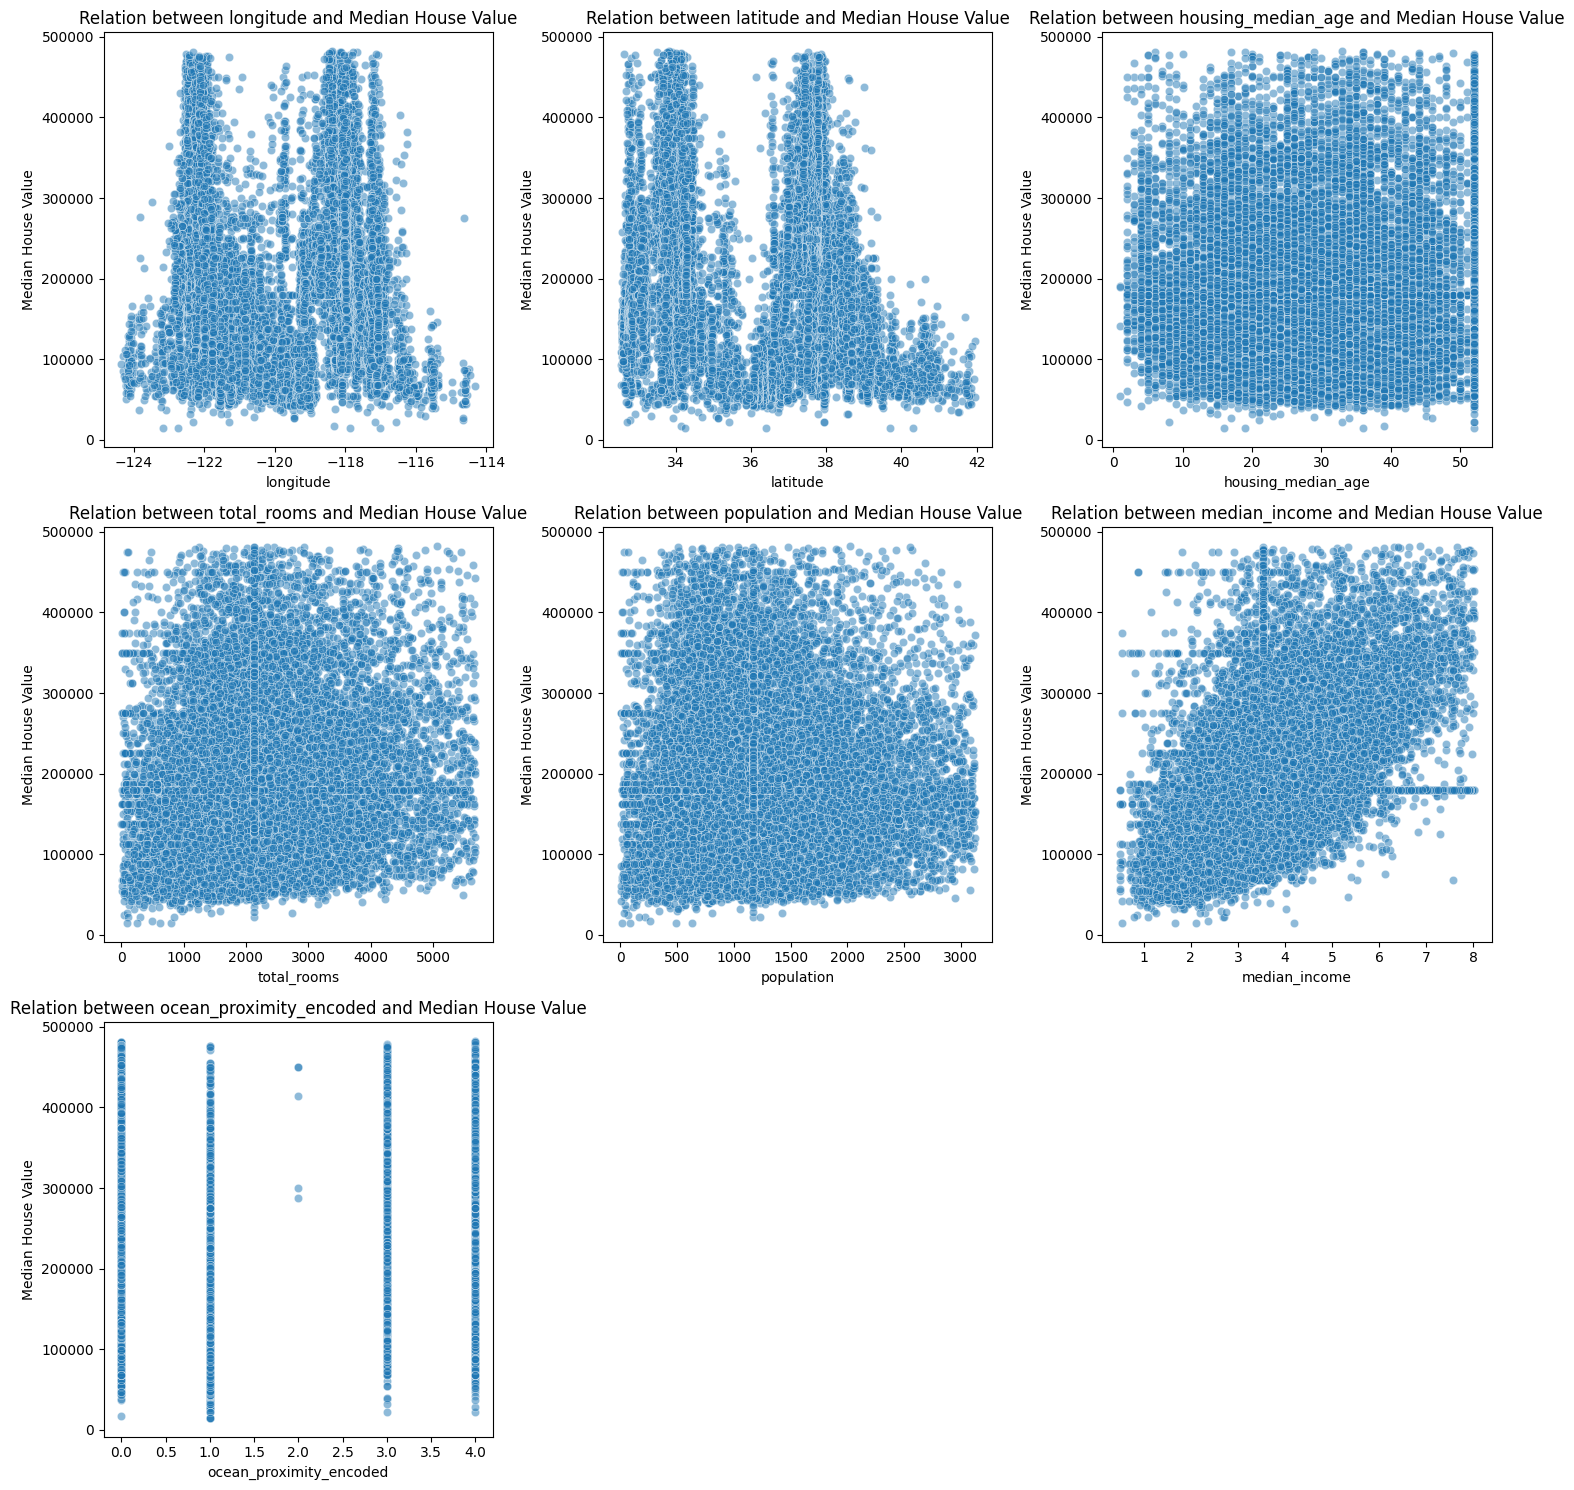

In [ ]:
# Prepare the features and grid layout
features = df.drop(columns=['median_house_value', 'ocean_proximity']).columns
n_cols = 3  # 3 columns in the grid
n_rows = math.ceil(len(features) / n_cols)  # Calculate rows needed for the grid

plt.figure(figsize=(15, 5 * n_rows))

# Create subplots
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(x=df[feature], y=df['median_house_value'], alpha=0.5)
    plt.title(f"Relation between {feature} and Median House Value")
    plt.xlabel(feature)
    plt.ylabel("Median House Value")

plt.tight_layout()
plt.show()

### Preprocessing Imbalance and Skewed Feature

In [ ]:
#Use logarithmic transformations to reduce skewness and imbalance
#total_rooms and population have some coleration with “median_house_value”, so better reduce skewness and imbalance
df['total_rooms'] = np.log1p(df['total_rooms'])
df['population'] = np.log1p(df['population'])

### Standardisation

In [ ]:
df_pre=df.copy()
#Scale columns
scaler = StandardScaler()
df_pre.drop(columns=['ocean_proximity'], inplace=True)
scaled_columns=df_pre.drop(columns=['ocean_proximity_encoded','median_house_value']).columns

# Apply scaling to the selected columns
scaled_values = scaler.fit_transform(df_pre[scaled_columns])

# Convert the scaled array back to a DataFrame
df_scaled = pd.DataFrame(scaled_values, columns=scaled_columns, index=df_pre.index)

# Add 'ocean_proximity_encoded' into the scaled DataFrame
df_scaled['ocean_proximity_encoded'] = df_pre['ocean_proximity_encoded']
df_scaled['median_house_value'] = df_pre['median_house_value']

# Display the first few rows of the scaled DataFrame
df_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity_encoded,median_house_value
0,-1.327314,1.051717,0.982163,-1.167309,-1.800225,-0.080765,3.0,452600.0
1,-1.322323,1.042355,-0.606210,0.181424,1.285999,-0.080765,3.0,358500.0
2,-1.332305,1.037674,1.855769,-0.386408,-1.137362,2.458941,3.0,352100.0
3,-1.337296,1.037674,1.855769,-0.601982,-0.956534,1.357098,3.0,341300.0
4,-1.337296,1.037674,1.855769,-0.228191,-0.937392,0.130622,3.0,342200.0


### Feature Distribution after Feature Engineering

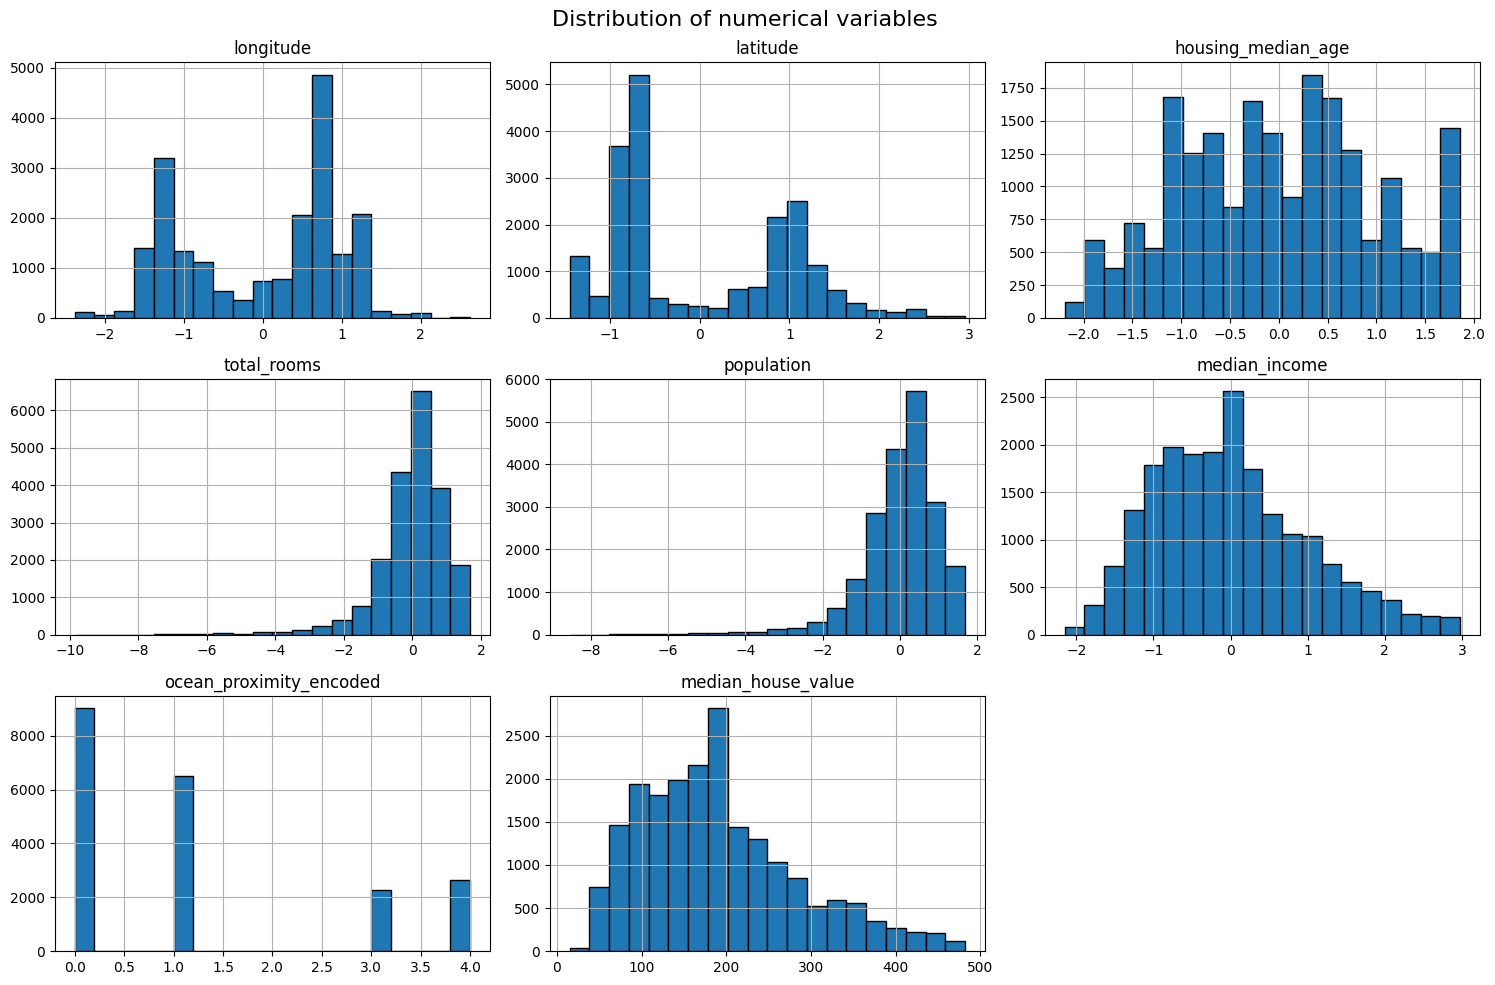

In [ ]:
df_scaled.hist(bins=20, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribution of numerical variables", fontsize=16)
plt.tight_layout()
plt.show()

The distribution fo "ocean_proximity_encoded" shows a clear imbalance, with certain categories being much more frequent than others. This is typical for categorical data.
"median_house_value" and "median_incomes" appear slightly skewed, but this is common in housing datasets, where lower-priced homes or lower-income groups often dominate.

## Machine Learning

### Definition of features and target

In [ ]:
#Define features and target
target=df_scaled['median_house_value']
target/=1000
features=df_scaled.drop(columns=['median_house_value'])
target.head()
#target.describe()

,median_house_value
0,452.6
1,358.5
2,352.1
3,341.3
4,342.2


In [ ]:
features.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity_encoded
0,-1.327314,1.051717,0.982163,-1.167309,-1.800225,-0.080765,3.0
1,-1.322323,1.042355,-0.606210,0.181424,1.285999,-0.080765,3.0
2,-1.332305,1.037674,1.855769,-0.386408,-1.137362,2.458941,3.0
3,-1.337296,1.037674,1.855769,-0.601982,-0.956534,1.357098,3.0
4,-1.337296,1.037674,1.855769,-0.228191,-0.937392,0.130622,3.0


### Train/Test Splitting and Model Definition

In [ ]:
# Split the preprocessed features and target into training and testing sets with shuffle
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=True, random_state=42)

In [ ]:
# Define regression models
from sklearn.ensemble import GradientBoostingRegressor
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GBR' : GradientBoostingRegressor(random_state=42)
}

### Training with train/test split

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"{model_name} Results on Test Set:")
    print(f"  R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"  Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred) * 100:.3f} %")
    print(f"  Median absolute error: {median_absolute_error(y_test, y_pred):.3f} k$ \n")

LinearRegression Results on Test Set:
  R² Score: 0.476
  Mean absolute percentage error: 31.120 %
  Median absolute error: 39.200 k$ 

DecisionTree Results on Test Set:
  R² Score: 0.422
  Mean absolute percentage error: 24.725 %
  Median absolute error: 24.700 k$ 

RandomForest Results on Test Set:
  R² Score: 0.691
  Mean absolute percentage error: 19.264 %
  Median absolute error: 20.356 k$ 

GBR Results on Test Set:
  R² Score: 0.592
  Mean absolute percentage error: 24.022 %
  Median absolute error: 29.057 k$ 



### Training with Cross-validation KFold=5 Shuffle

In [ ]:
for model_name, model in models.items():

    # Cross-validation
    cv_scores = cross_val_score(model, features, target, cv=KFold(5, shuffle=True), scoring='r2', n_jobs=-1)#Shuffle the dataset because it is coordinated

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"{model_name} Results on Test Set:")
    print(f"  Cross-validated R² Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"  Cross-validated Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred) * 100:.3f} %")
    print(f"  Cross-validated Median absolute error: {median_absolute_error(y_test, y_pred):.3f} k$ \n")

LinearRegression Results on Test Set:
  Cross-validated R² Score: 0.484 ± 0.013
  Cross-validated Mean absolute percentage error: 31.120 %
  Cross-validated Median absolute error: 39.200 k$ 

DecisionTree Results on Test Set:
  Cross-validated R² Score: 0.402 ± 0.014
  Cross-validated Mean absolute percentage error: 24.725 %
  Cross-validated Median absolute error: 24.700 k$ 

RandomForest Results on Test Set:
  Cross-validated R² Score: 0.690 ± 0.010
  Cross-validated Mean absolute percentage error: 19.264 %
  Cross-validated Median absolute error: 20.356 k$ 

GBR Results on Test Set:
  Cross-validated R² Score: 0.600 ± 0.006
  Cross-validated Mean absolute percentage error: 24.022 %
  Cross-validated Median absolute error: 29.057 k$ 



### Training with Cross-validation KFold=10

In [ ]:
for model_name, model in models.items():
    print(f"Training {model_name}...")

    cv_results = cross_validate(model, features, target,cv=KFold(10, shuffle=True))
    scores = cv_results["test_score"] #default score is R2
    print(f"The R2 score is: {scores.mean():.3f} ± {scores.std():.3f}")

Training LinearRegression...
The R2 score is: 0.484 ± 0.015
Training DecisionTree...
The R2 score is: 0.417 ± 0.027
Training RandomForest...
The R2 score is: 0.699 ± 0.012


Performence lightly improved for cv=10.
But don't need to increase cv, that will increase much training time.

### Hyperparameter Searching - GridSearch

Use cross-validation to tune the huperparameters of the model, and evaluate the model on the test set

In [ ]:
# Define parameter grids for each regression model
param_grids = {
    'LinearRegression': {
        # No hyperparameters to tune for LinearRegression in scikit-learn
    },
    'DecisionTree': {
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    },
    'GBR' : {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
    }
}

tuned_models = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")

    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=KFold(5, shuffle=True), scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    tuned_models[model_name] = grid_search.best_estimator_

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

# Evaluate each tuned model on the test set
for model_name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} Results on Test Set:")
    print(f"  R² Score: {r2:.3f}")
    print(f"  Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred) * 100:.3f} %")
    print(f"  Median absolute error: {median_absolute_error(y_test, y_pred):.3f} k$ \n")

Tuning LinearRegression...
Best parameters for LinearRegression: {}
Tuning DecisionTree...
Best parameters for DecisionTree: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Tuning RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Tuning GBR...
Best parameters for GBR: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
LinearRegression Results on Test Set:
  R² Score: 0.476
  Mean absolute percentage error: 31.120 %
  Median absolute error: 39.200 k$ 

DecisionTree Results on Test Set:
  R² Score: 0.585
  Mean absolute percentage error: 22.548 %
  Median absolute error: 25.292 k$ 

RandomForest Results on Test Set:
  R² Score: 0.693
  Mean absolute percentage error: 19.162 %
  Median absolute error: 20.226 k$ 

GBR Results on Test Set:
  R² Score: 0.691
  Mean absolute percentage error: 19.473 %
  Median absolute error: 21.059 k$ 



### Nested cross-validation

Use a nested cross-validation, with an inner cross-validation to tune the parameters of the model and an outer cross-validation to evaluate the model's performance

In [ ]:
from sklearn.metrics import make_scorer
# Define custom scoring for MAPE and MAE
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mae_scorer = make_scorer(median_absolute_error, greater_is_better=False)

# Define outer cv
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Loop through each model
for model_name, model in tuned_models.items():

    print(f"{model_name} Results on Test Set:")

    # Evaluate the best model using outer cross-validation
    scores_r2 = cross_val_score(model, features, target, cv=outer_cv, scoring='r2', n_jobs=-1)
    print(f"  Nested Cross-validated R²: {scores_r2.mean():.3f} ± {scores.std():.3f}")

    scores_mape = cross_val_score(model, features, target, cv=outer_cv, scoring=mape_scorer, n_jobs=-1)
    print(f"  Nested Cross-validated Mean absolute percentage error: {abs(scores_mape.mean()) * 100:.3f} % ± {scores_mape.std()* 100:.3f} %")

    scores_mae = cross_val_score(model, features, target, cv=outer_cv, scoring=mae_scorer, n_jobs=-1)
    print(f"  Nested Cross-validated Median absolute error: {abs(scores_mae.mean()):.3f}k$ ± {scores_mae.std():.3f}k$ \n")

LinearRegression Results on Test Set:
  Nested Cross-validated R²: 0.484 ± 0.011
  Nested Cross-validated Mean absolute percentage error: 30.955 % ± 0.315 %
  Nested Cross-validated Median absolute error: 39.026k$ ± 0.241k$ 

DecisionTree Results on Test Set:
  Nested Cross-validated R²: 0.585 ± 0.011
  Nested Cross-validated Mean absolute percentage error: 22.832 % ± 0.225 %
  Nested Cross-validated Median absolute error: 25.831k$ ± 0.334k$ 

RandomForest Results on Test Set:
  Nested Cross-validated R²: 0.686 ± 0.011
  Nested Cross-validated Mean absolute percentage error: 19.357 % ± 0.223 %
  Nested Cross-validated Median absolute error: 20.921k$ ± 0.436k$ 

GBR Results on Test Set:
  Nested Cross-validated R²: 0.688 ± 0.011
  Nested Cross-validated Mean absolute percentage error: 19.348 % ± 0.256 %
  Nested Cross-validated Median absolute error: 21.284k$ ± 0.118k$ 



We observe that the generalization performance estimated with using nested CV is almost as same as what we obtain without nested CV. The tuning procedure itself selects the model with the highest inner CV score. If there are many hyper-parameter combinations and if the inner CV scores have comparatively large standard deviations, taking the maximum value can lure us into over-estimating the true generalization performance of the result of the full learning procedure. By using an outer cross-validation procedure one gets a more trustworthy estimate of the generalization performance of the full learning procedure, including the effect of tuning the hyperparameters.

**By comparing with the results we obtained in the GridSearch step, we can find that our model in the GridSearch step is trustworthy.**


### Model Assessment
**Linear Regression** : Weak performance, it does not capture the complex relationships between features and target, making it unreliable for this prediction.

---

**Decision Tree** : Better performance. However, this model remains limited in its ability to generalize across complex data sets.

---

**Random Forest** : Robust and consistent performance due to the use of multiple trees. It exhibits lower errors (MAPE of 19.357%, MedAE of $20.921k) and captures non-linear relationships well, making it suitable for this project's data.

---

**Gradient Boosting Regressor** : Highest overall performance. Although it is slightly more resource intensive, it performs best in capturing data complexity.

### Ablation Study

In [ ]:
features_list = list(features.columns)
ablation_results = []

model_rf = RandomForestRegressor(max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

base_r2 = r2_score(y_test, y_pred)
mape=mean_absolute_percentage_error(y_test, y_pred) * 100
mae=median_absolute_error(y_test, y_pred)
ablation_results.append({'Removed Feature(s)': 'None', 'R²': base_r2, 'Mean absolute percentage error': mape, 'Median absolute error' : mae})

print(f"Training with all features - R²: {r2:.3f}, Mean absolute percentage error: {mape:.3f}, Median absolute error: {mae:.3f}")

# Ablation Study: Remove One Feature at a Time
for feature in features_list:
    print(f"\nRemoving Feature: {feature}")

    # Remove feature
    X_train_ablation = X_train.drop(columns=[feature])
    X_test_ablation = X_test.drop(columns=[feature])

    # Train the model
    model_rf.fit(X_train_ablation, y_train)
    y_pred_ablation = model_rf.predict(X_test_ablation)

    # Calculate Metrics
    mape=mean_absolute_percentage_error(y_test, y_pred_ablation) * 100
    mae=median_absolute_error(y_test, y_pred_ablation)
    r2 = r2_score(y_test, y_pred_ablation)
    ablation_results.append({'Removed Feature(s)': feature, 'R²': r2, 'Mean absolute percentage error': mape, 'Median absolute error' : mae})

    print(f"After Removing {feature} - R²: {r2:.3f}, Mean absolute percentage error: {mape:.3f}, Median absolute error: {mae:.3f}")

ablation_df = pd.DataFrame(ablation_results)
print("\nAblation Study Results:")
print(ablation_df)

Training with all features - R²: 0.691, Mean absolute percentage error: 19.204, Median absolute error: 20.276

Removing Feature: longitude
After Removing longitude - R²: 0.613, Mean absolute percentage error: 22.749, Median absolute error: 26.849

Removing Feature: latitude
After Removing latitude - R²: 0.621, Mean absolute percentage error: 22.651, Median absolute error: 25.755

Removing Feature: housing_median_age
After Removing housing_median_age - R²: 0.687, Mean absolute percentage error: 19.354, Median absolute error: 20.467

Removing Feature: total_rooms
After Removing total_rooms - R²: 0.689, Mean absolute percentage error: 19.245, Median absolute error: 19.887

Removing Feature: population
After Removing population - R²: 0.692, Mean absolute percentage error: 19.092, Median absolute error: 20.085

Removing Feature: median_income
After Removing median_income - R²: 0.650, Mean absolute percentage error: 21.000, Median absolute error: 22.070

Removing Feature: ocean_proximity_enc

**Critical Features:**

“median_income”: Removing it degrades performance. It is essential to explain variance in house prices.

“longitude” and “latitude”: These two features are important because they capture geographic information that is essential to predicting prices.

---

**Moderately Important Features:**

“housing_median_age”: Relevant, but its absence only slightly degrades performance.

“total_rooms”: Not very informative on its own.

---

**Less Relevant Features:**

“population”: Very little impact on performance.

“ocean_proximity_encoded”: Low value added to the model, which may indicate that this categorical variable does not capture enough nuance.